In [1]:
from google.cloud import bigquery
import pandas

In [2]:
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: ut-goog


# Looking at the first half of the columns from the dataset.

In [3]:
query = """
    SELECT 
        date_received, 
        product, subproduct, 
        issue, subissue, 
        consumer_complaint_narrative, 
        company_public_response, 
        company_name, 
        state 
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

complaints_df = query_job.to_dataframe()
complaints_df

,date_received,product,subproduct,issue,subissue,consumer_complaint_narrative,company_public_response,company_name,state
0,2017-03-26,Credit card,None,Late fee,None,None,None,Alliance Data Card Services,IL
1,2020-04-29,Credit card or prepaid card,General-purpose prepaid card,Advertising,Confusing or misleading advertising about the ...,None,None,AMERICAN EXPRESS COMPANY,CA
2,2020-04-17,Credit card or prepaid card,General-purpose prepaid card,Advertising,Confusing or misleading advertising about the ...,None,None,AMERICAN EXPRESS COMPANY,NY
3,2020-04-10,Credit card or prepaid card,General-purpose prepaid card,Advertising,Changes in terms from what was offered or adve...,None,None,BARCLAYS BANK DELAWARE,NY
4,2020-04-09,"Money transfer, virtual currency, or money ser...",International money transfer,Fraud or scam,None,None,None,"BANK OF AMERICA, NATIONAL ASSOCIATION",TX
...,...,...,...,...,...,...,...,...,...
1598293,2019-03-08,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,None,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",MO
1598294,2018-12-27,Mortgage,Conventional home mortgage,Trouble during payment process,None,I was a participant in the class settlement wi...,None,Ocwen Financial Corporation,NC
1598295,2018-12-05,Checking or savings account,Other banking product or service,Managing an account,Problem making or receiving payments,None,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,NC
1598296,2017-01-20,Student loan,Federal student loan servicing,Can't repay my loan,Can't temporarily postpone payments,My income sensitive payments were stopped with...,None,"Navient Solutions, LLC.",GA


# Looking at null values by column
Percentage of missing values by columns

In [4]:
(complaints_df.isnull().sum()/len(complaints_df)*100).sort_values(ascending=False)

consumer_complaint_narrative    66.817953
company_public_response         61.611352
subissue                        35.563393
subproduct                      14.713464
state                            1.696304
company_name                     0.000000
issue                            0.000000
product                          0.000000
date_received                    0.000000
dtype: float64

### Can see that the narrative is the highest missing. 

In [5]:
(len(complaints_df)-complaints_df.isnull().sum()).sort_values()

consumer_complaint_narrative     530348
company_public_response          613565
subissue                        1029889
subproduct                      1363133
state                           1571186
date_received                   1598298
product                         1598298
issue                           1598298
company_name                    1598298
dtype: int64

### We have half a million complaint narratives that we can use the NLP API on.

In [6]:
complaints_df.dtypes

date_received                   object
product                         object
subproduct                      object
issue                           object
subissue                        object
consumer_complaint_narrative    object
company_public_response         object
company_name                    object
state                           object
dtype: object

### Looking at Products and Subproducts

In [7]:
query = """
    SELECT 
        product, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    WHERE
        consumer_complaint_narrative IS NOT NULL
    GROUP BY
        product
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

products_df = query_job.to_dataframe()
products_df

,product,total
0,"Credit reporting, credit repair services, or o...",164924
1,Debt collection,113278
2,Mortgage,64542
3,Credit card or prepaid card,36067
4,Credit reporting,31588
5,Student loan,25987
6,Checking or savings account,21151
7,Credit card,18838
8,Bank account or service,14885
9,Consumer Loan,9473


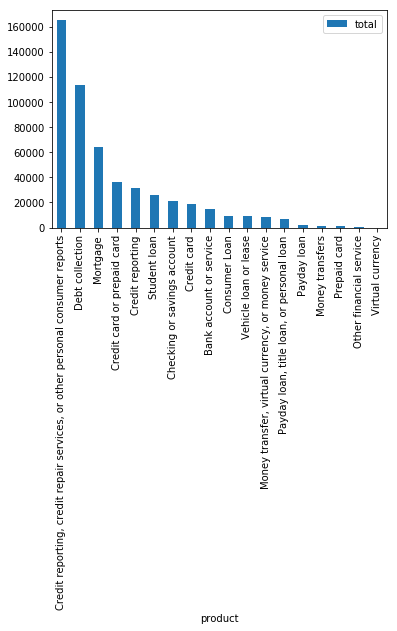

In [8]:
products_df.plot(kind="bar",x='product')

In [9]:
products_df

,product,total
0,"Credit reporting, credit repair services, or o...",164924
1,Debt collection,113278
2,Mortgage,64542
3,Credit card or prepaid card,36067
4,Credit reporting,31588
5,Student loan,25987
6,Checking or savings account,21151
7,Credit card,18838
8,Bank account or service,14885
9,Consumer Loan,9473


Most have to do with credit and debt. Also, notice that a lot of the labels are very similar (i.e. "credit card", "prepaid card", "credit card or prepaid card"). Might have to find a way to wrap these up.

### Look at and maybe combine some of the products?
### Could the different product labels be due to different companies? or maybe they changed over time with the form?

In [10]:
query = """
    SELECT 
        company_name, product, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    WHERE
        consumer_complaint_narrative IS NOT NULL
    GROUP BY
        company_name, product
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

products_company_df = query_job.to_dataframe()

In [11]:
products_company_df[:10]

,company_name,product,total
0,"EQUIFAX, INC.","Credit reporting, credit repair services, or o...",45325
1,Experian Information Solutions Inc.,"Credit reporting, credit repair services, or o...",41296
2,"TRANSUNION INTERMEDIATE HOLDINGS, INC.","Credit reporting, credit repair services, or o...",39645
3,"Navient Solutions, LLC.",Student loan,12645
4,"EQUIFAX, INC.",Credit reporting,11370
5,Experian Information Solutions Inc.,Credit reporting,9248
6,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Credit reporting,9105
7,WELLS FARGO & COMPANY,Mortgage,6451
8,"CITIBANK, N.A.",Credit card or prepaid card,5845
9,Ocwen Financial Corporation,Mortgage,5166


In [12]:
products_company_df[products_company_df['company_name']=='EQUIFAX, INC.']

,company_name,product,total
0,"EQUIFAX, INC.","Credit reporting, credit repair services, or o...",45325
4,"EQUIFAX, INC.",Credit reporting,11370
88,"EQUIFAX, INC.",Debt collection,827
552,"EQUIFAX, INC.",Credit card or prepaid card,92
1456,"EQUIFAX, INC.",Mortgage,25
1520,"EQUIFAX, INC.",Consumer Loan,23
1805,"EQUIFAX, INC.",Student loan,18
1853,"EQUIFAX, INC.",Vehicle loan or lease,17
2336,"EQUIFAX, INC.",Credit card,11
3288,"EQUIFAX, INC.","Payday loan, title loan, or personal loan",6


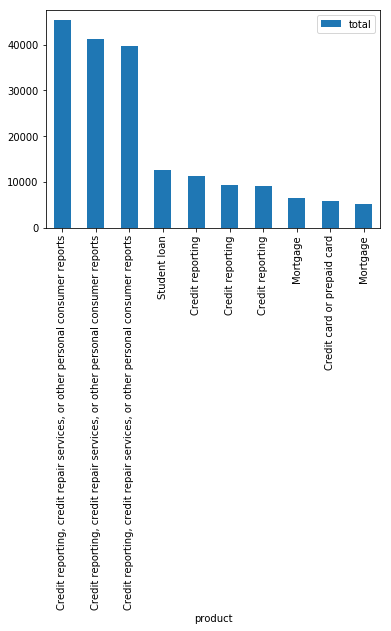

In [13]:
products_company_df[:10].plot(kind='bar',x='product')

Most complaints for the companies seem to be about credit cards or credit. Looks like the differing labels for the categories are not company related. This makes sense since the complaints go through the CFPB and thus are probably standardized. The differing labels may be due to the complaint form changing overtime. 

### Lets look at subproducts to see if there is a reason for the different product types

In [14]:
query = """
    SELECT 
        subproduct, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    WHERE
        consumer_complaint_narrative IS NOT NULL
    GROUP BY
        subproduct
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

subproducts_df = query_job.to_dataframe()
subproducts_df

,subproduct,total
0,Credit reporting,161366
1,None,52172
2,Checking account,27677
3,General-purpose credit card or charge card,27508
4,I do not know,22272
...,...,...
71,Credit repair,39
72,Traveler’s/Cashier’s checks,22
73,Transit card,19
74,Student prepaid card,4


In [15]:
query = """
    SELECT 
        product, subproduct, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    WHERE
        consumer_complaint_narrative IS NOT NULL
    GROUP BY
        product, subproduct
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

products3_df = query_job.to_dataframe()
products3_df[:20]

,product,subproduct,total
0,"Credit reporting, credit repair services, or o...",Credit reporting,161366
1,Credit reporting,None,31588
2,Credit card or prepaid card,General-purpose credit card or charge card,27508
3,Debt collection,I do not know,22272
4,Debt collection,Other debt,20703
5,Mortgage,Conventional home mortgage,19159
6,Credit card,None,18838
7,Checking or savings account,Checking account,17564
8,Debt collection,Credit card debt,16249
9,Student loan,Federal student loan servicing,15023


Notice row 3, "I do not know". What does this mean? 

Also, looks like we can combine some subproducts, i.e. "credit card debt" and "credit card or medical debt" and "medical". Or at the at least look into why they are all seperated.

In [16]:
products3_df[products3_df['product'] == 'Credit card or prepaid card']

,product,subproduct,total
2,Credit card or prepaid card,General-purpose credit card or charge card,27508
18,Credit card or prepaid card,Store credit card,6318
44,Credit card or prepaid card,General-purpose prepaid card,1482
61,Credit card or prepaid card,Government benefit card,449
67,Credit card or prepaid card,Gift card,162
71,Credit card or prepaid card,Payroll card,144
94,Credit card or prepaid card,Student prepaid card,4


The just credit card product has no subproduct but the one that combines credit card and prepaid card does. Do they mean different things?

# Looking at issues and subissues

In [17]:
query = """
    SELECT 
        issue, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    WHERE
        consumer_complaint_narrative IS NOT NULL
    GROUP BY
        issue
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

issue_df = query_job.to_dataframe()
issue_df[:10]

,issue,total
0,Incorrect information on your report,92790
1,Problem with a credit reporting company's inve...,44416
2,Attempts to collect debt not owed,32080
3,Improper use of your report,21861
4,Incorrect information on credit report,21217
5,Cont'd attempts collect debt not owed,17434
6,Trouble during payment process,14970
7,"Loan servicing, payments, escrow account",14722
8,Communication tactics,14479
9,Written notification about debt,13723


Can see some looks repetitive.

In [18]:
query = """
    SELECT 
        company_name, issue, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    WHERE
        consumer_complaint_narrative IS NOT NULL
    GROUP BY
        company_name, issue
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

issue2_df = query_job.to_dataframe()
issue2_df[:10]

,company_name,issue,total
0,Experian Information Solutions Inc.,Incorrect information on your report,23565
1,"EQUIFAX, INC.",Incorrect information on your report,22901
2,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Incorrect information on your report,22482
3,"EQUIFAX, INC.",Problem with a credit reporting company's inve...,11923
4,Experian Information Solutions Inc.,Problem with a credit reporting company's inve...,11625
5,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Problem with a credit reporting company's inve...,11053
6,"EQUIFAX, INC.",Incorrect information on credit report,7630
7,"EQUIFAX, INC.",Improper use of your report,6796
8,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Incorrect information on credit report,6427
9,Experian Information Solutions Inc.,Incorrect information on credit report,5765


In [19]:
query = """
    SELECT 
        subissue, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    WHERE
        consumer_complaint_narrative IS NOT NULL
    GROUP BY
        subissue
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

subissue_df = query_job.to_dataframe()
subissue_df[:10]

,subissue,total
0,None,132915
1,Information belongs to someone else,41521
2,Their investigation did not fix an error on yo...,31530
3,Account status incorrect,17788
4,Account information incorrect,16854
5,Debt is not yours,16390
6,Credit inquiries on your report that you don't...,14282
7,Debt was paid,11819
8,Debt is not mine,10105
9,Attempted to collect wrong amount,8785


debt is not mine and debt is not yours seem to be the same thing?

In [20]:
query = """
    SELECT 
        issue, subissue, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    WHERE
        consumer_complaint_narrative IS NOT NULL
    GROUP BY
        issue, subissue
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

subissue2_df = query_job.to_dataframe()
subissue2_df[:15]

,issue,subissue,total
0,Incorrect information on your report,Information belongs to someone else,41521
1,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,31368
2,Incorrect information on your report,Account status incorrect,17788
3,Incorrect information on your report,Account information incorrect,16854
4,Attempts to collect debt not owed,Debt is not yours,16390
5,Trouble during payment process,None,14970
6,"Loan servicing, payments, escrow account",None,14722
7,Improper use of your report,Credit inquiries on your report that you don't...,14282
8,"Loan modification,collection,foreclosure",None,10789
9,Cont'd attempts collect debt not owed,Debt is not mine,10105


# Looking At Which Companies Had The Most Complaints

In [21]:
query = """
    SELECT 
        company_name, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    WHERE
        consumer_complaint_narrative IS NOT NULL
    GROUP BY
        company_name
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

companies_df = query_job.to_dataframe()
companies_df

,company_name,total
0,"EQUIFAX, INC.",57724
1,Experian Information Solutions Inc.,51387
2,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",49583
3,"CITIBANK, N.A.",17620
4,WELLS FARGO & COMPANY,17107
...,...,...
4527,Perennial Funding LLC,1
4528,"Aswad & Ingraham, LLP",1
4529,Sands Recovery Group,1
4530,"Concorde Land Title Services, Inc.",1


In [22]:
query = """
    SELECT 
        company_name, COUNT(complaint_id) as total, (COUNT(complaint_id)/1498059)*100 as percentage
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    WHERE
        consumer_complaint_narrative IS NOT NULL
    GROUP BY
        company_name
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

companies_df2 = query_job.to_dataframe()
companies_df2

,company_name,total,percentage
0,"EQUIFAX, INC.",57724,3.853253
1,Experian Information Solutions Inc.,51387,3.430239
2,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",49583,3.309816
3,"CITIBANK, N.A.",17620,1.176189
4,WELLS FARGO & COMPANY,17107,1.141944
...,...,...,...
4527,Perennial Funding LLC,1,0.000067
4528,"Aswad & Ingraham, LLP",1,0.000067
4529,Sands Recovery Group,1,0.000067
4530,"Concorde Land Title Services, Inc.",1,0.000067


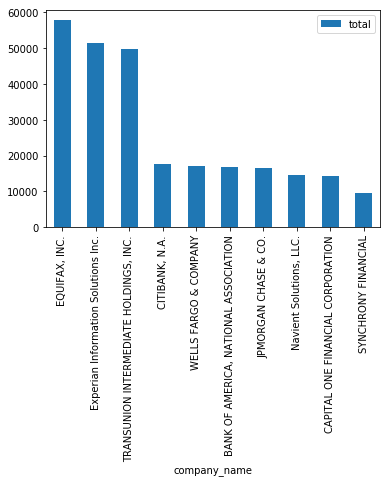

In [23]:
companies_df2[:10].plot(kind='bar', x='company_name',y='total')

# Checking if companies have different spellings

In [24]:
query = """
    SELECT 
        DISTINCT(company_name)
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    WHERE
        company_name LIKE "C%"
    ORDER BY company_name
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

companies_df3 = query_job.to_dataframe()
companies_df3[:30]

,company_name
0,"C & A Mortgage Services of Florence, Inc."
1,"C & E Financial Group, Inc."
2,"C & M Associates Group, Inc."
3,"C & S Auto Enterprises, Inc"
4,C B Merchant Services
5,C&F MORTGAGE CORPORATION
6,"C&H INVESTMENTS, INC."
7,C. Edwin Walker Attorney at Law
8,"C.Tech Collections, Inc."
9,C/C Financial


Doesn't look like there are different named spellings but more analysis could be performed.

# Looking at the states sorted by most complaints

In [25]:
query = """
    SELECT 
        state, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    WHERE
        consumer_complaint_narrative IS NOT NULL
    GROUP BY
        state
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

state_df = query_job.to_dataframe()
state_df

,state,total
0,CA,70791
1,FL,54600
2,TX,49684
3,GA,32305
4,NY,30344
...,...,...
59,AA,11
60,AS,8
61,MP,7
62,MH,3


Looks like the data includes US territories as well. For example, "AS" means American Samoa.

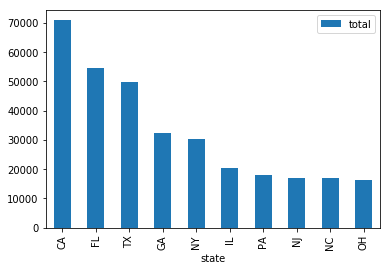

In [26]:
state_df[:10].plot(kind='bar', x='state')

Complaints by state seemed to be correlated by population size.

# Resolution

Here we will look at how the company publicly responded to the complaint.

In [27]:
query = """
    SELECT 
        company_public_response, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    WHERE
        consumer_complaint_narrative IS NOT NULL
    GROUP BY
        company_public_response
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

response_df = query_job.to_dataframe()
response_df[:10]

,company_public_response,total
0,None,270096
1,Company has responded to the consumer and the ...,190286
2,Company believes it acted appropriately as aut...,35668
3,Company chooses not to provide a public response,19818
4,Company believes the complaint is the result o...,3409
5,Company disputes the facts presented in the co...,3315
6,Company believes complaint caused principally ...,2368
7,Company believes complaint is the result of an...,2359
8,Company believes complaint represents an oppor...,1783
9,Company can't verify or dispute the facts in t...,1207


In [28]:
response_df['company_public_response'][2]

'Company believes it acted appropriately as authorized by contract or law'

Most companies chose to have no response. We might also need to look into the difference between what the difference between "None" and the "Company chooses not to provied a public response".

### Maybe there is a trend or pattern that indicates some companies are more prone to certain public reponses over others?

In [29]:
query = """
    SELECT 
        company_name, company_public_response, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    WHERE
        consumer_complaint_narrative IS NOT NULL
    GROUP BY
        company_name, company_public_response
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

response2_df = query_job.to_dataframe()
response2_df[:10]

,company_name,company_public_response,total
0,"EQUIFAX, INC.",None,57724
1,Experian Information Solutions Inc.,Company has responded to the consumer and the ...,47839
2,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Company has responded to the consumer and the ...,45895
3,JPMORGAN CHASE & CO.,None,16528
4,"CITIBANK, N.A.",Company has responded to the consumer and the ...,15093
5,CAPITAL ONE FINANCIAL CORPORATION,None,14310
6,"Navient Solutions, LLC.",None,14256
7,WELLS FARGO & COMPANY,Company has responded to the consumer and the ...,13999
8,"BANK OF AMERICA, NATIONAL ASSOCIATION",Company has responded to the consumer and the ...,13528
9,SYNCHRONY FINANCIAL,Company has responded to the consumer and the ...,8283


Two reponse types seem to be the most common. Also, big companies like Equifax, Chase, and Capital One seem to prefer the "None" response. Why is that?

In [30]:
response2_df[response2_df['company_name']=='EQUIFAX, INC.']

,company_name,company_public_response,total
0,"EQUIFAX, INC.",None,57724


In [31]:
response2_df[response2_df['company_name']=='JPMORGAN CHASE & CO.']

,company_name,company_public_response,total
3,JPMORGAN CHASE & CO.,None,16528
5795,JPMORGAN CHASE & CO.,Company has responded to the consumer and the ...,2


Why does JP Morgan and Equifax mainly have "None" as its response?

In [32]:
response2_df[response2_df['company_public_response']=='Company believes it acted appropriately as authorized by contract or law'][:10]

,company_name,company_public_response,total
27,ERC,Company believes it acted appropriately as aut...,2558
31,"SELECT PORTFOLIO SERVICING, INC.",Company believes it acted appropriately as aut...,2243
32,UNITED SERVICES AUTOMOBILE ASSOCIATION,Company believes it acted appropriately as aut...,2177
39,Ditech Financial LLC,Company believes it acted appropriately as aut...,1842
40,NAVY FEDERAL CREDIT UNION,Company believes it acted appropriately as aut...,1836
56,"Shellpoint Partners, LLC",Company believes it acted appropriately as aut...,1133
75,GREAT LAKES,Company believes it acted appropriately as aut...,721
83,SLM CORPORATION,Company believes it acted appropriately as aut...,690
101,Phoenix Financial Services LLC,Company believes it acted appropriately as aut...,555
116,"I.Q. DATA INTERNATIONAL, INC.",Company believes it acted appropriately as aut...,472


Looks like many of the "smaller" companies believe that they have acted appropriately.

# Looking at date

In [33]:
query = """
    SELECT 
        extract(year from date_received) as year, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    WHERE
        consumer_complaint_narrative IS NOT NULL
    GROUP BY
       year
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

year_df = query_job.to_dataframe()

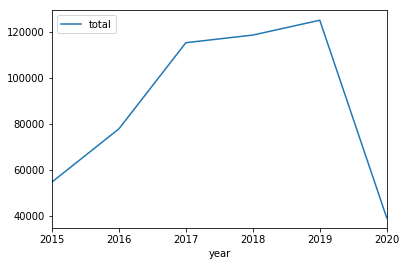

In [34]:
year_df.sort_values(by='year').plot(x='year')

In [35]:
year_df.sort_values(by='year')

,year,total
4,2015,54753
3,2016,77819
2,2017,115176
1,2018,118485
0,2019,124914
5,2020,39201


Data all the way from 2011 but only 2015 and on has consumer complaint narratives. 2020 drops due to not being a full year yet.

In [36]:
query = """
    SELECT 
        extract(month from date_received) as month, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    WHERE
        consumer_complaint_narrative IS NOT NULL
    GROUP BY
       month
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

month_df = query_job.to_dataframe()

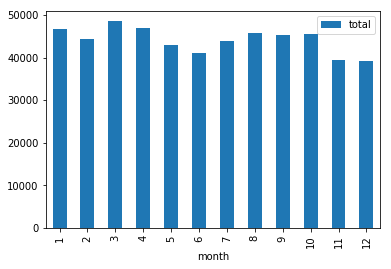

In [37]:
month_df.sort_values(by='month').plot(kind='bar',x='month')

In [38]:
query = """
    SELECT 
        date_received, COUNT(complaint_id) as total
    FROM 
        `bigquery-public-data.cfpb_complaints.complaint_database`
    WHERE
        consumer_complaint_narrative IS NOT NULL
    GROUP BY
        date_received
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

time_df = query_job.to_dataframe()

In [39]:
from datetime import datetime
time_df['date_received'] = pandas.to_datetime(time_df['date_received'])
time_df.set_index('date_received', inplace=True)
time_df.head()

,total
date_received,
2017-09-08,1890
2017-09-09,1369
2017-01-19,1013
2017-09-13,904
2017-01-20,809


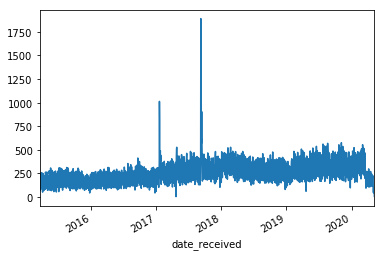

In [40]:
time_df['total'].plot()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


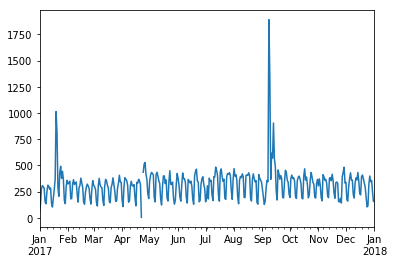

In [41]:
dates = pandas.date_range(start='1/1/2017', end='1/1/2018', freq='D')
time_df.loc[dates]['total'].plot()

Why those spikes?

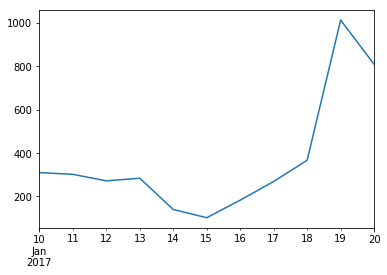

In [42]:
dates2 = pandas.date_range(start='1/10/2017', end='1/20/2017', freq='D')
time_df.loc[dates2]['total'].plot()

Low on the weekends, high on Thursday for this week.
# Now lets look at the other half of the columns

These columns look at zipcode, tags, and other variables that describe how the complaint resolved.

In [43]:
query = """
    SELECT 
        zip_code,
        tags,
        consumer_consent_provided,
        submitted_via,
        date_sent_to_company,
        company_response_to_consumer,
        timely_response,
        consumer_disputed,
        complaint_id
    FROM
        `bigquery-public-data.cfpb_complaints.complaint_database`
    WHERE
        consumer_complaint_narrative IS NOT NULL
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

second_half_df = query_job.to_dataframe()

In [44]:
second_half_df.describe()

,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,complaint_id
count,411520,90725,530348,530348,530348,530347,530348,164066,530348
unique,11197,3,1,1,1877,6,2,2,530348
top,300XX,Servicemember,Consent provided,Web,2017-09-08,Closed with explanation,True,False,2988114
freq,9396,54978,530348,530348,1783,429809,516424,128259,1


Looking at null values for the second half of the dataset columns.

In [45]:
(second_half_df.isnull().sum()/len(second_half_df)*100).sort_values(ascending=False)

tags                            82.893308
consumer_disputed               69.064463
zip_code                        22.405666
company_response_to_consumer     0.000189
complaint_id                     0.000000
timely_response                  0.000000
date_sent_to_company             0.000000
submitted_via                    0.000000
consumer_consent_provided        0.000000
dtype: float64

Tags seems to be missing in a majority of the rows. Same with the consumer_disputed variable.

In [46]:
second_half_df['zip_code'].value_counts().head(n=20)

300XX    9396
770XX    6283
606XX    5904
330XX    5762
331XX    5642
750XX    5562
303XX    4732
900XX    4646
891XX    4608
112XX    4312
334XX    4287
945XX    4191
302XX    4096
191XX    3397
333XX    3267
301XX    3224
852XX    3120
207XX    3103
282XX    3016
917XX    2928
Name: zip_code, dtype: int64

Looks like part of the zipcode is hidden.

Tag seems to be a classifier of some sort.

In [47]:
second_half_df['tags'].value_counts()

Servicemember                    54978
Older American                   28501
Older American, Servicemember     7246
Name: tags, dtype: int64

Only three groups. What does servicemember mean? What is the age cutoff for older American?

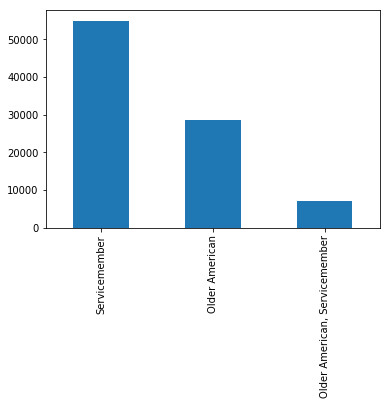

In [48]:
second_half_df['tags'].value_counts().plot(kind='bar')

Look at consumer consent

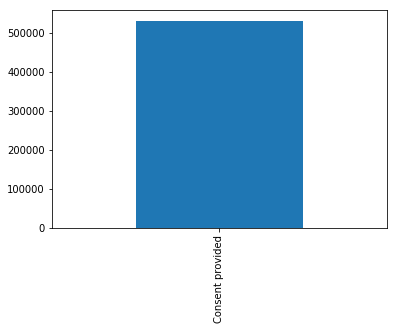

In [49]:
second_half_df['consumer_consent_provided'].value_counts().plot(kind='bar')

Only one label for this variable.

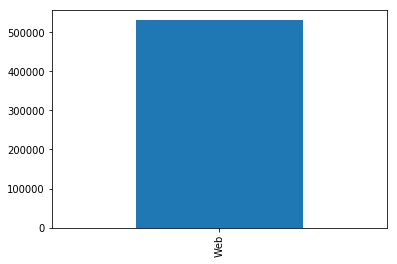

In [50]:
second_half_df['submitted_via'].value_counts().plot(kind='bar')

All complaints sent through the web.

### Possible company responses

In [51]:
second_half_df['company_response_to_consumer'].value_counts()

Closed with explanation            429809
Closed with non-monetary relief     65551
Closed with monetary relief         27915
Closed                               3741
Untimely response                    3329
In progress                             2
Name: company_response_to_consumer, dtype: int64

Probably want to put more emphasis on untimely response and closed with monetary relief. Focusing on these resolutions will save the company money and face-value.

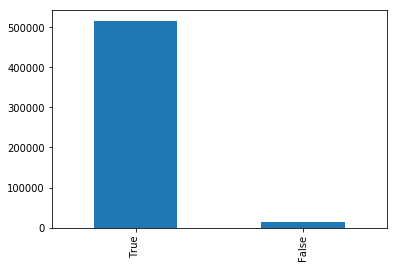

In [52]:
second_half_df['timely_response'].value_counts().plot(kind='bar')

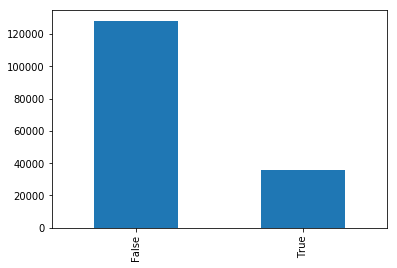

In [53]:
second_half_df['consumer_disputed'].value_counts().plot(kind='bar')

Most complaints are resolved in a timely manner and are not disputed.